# **Phishing Website Detection using RoBERTa**

- Uses XLM-RoBERTa embeddings (transformers) instead of TF-IDF.
- Trains on ../input/.../training and evaluates on ../input/.../validation (no leakage).
- Produces saved artifacts and prints final test results on the validation benchmark.

### **Libraries**

In [1]:
import os
import re
import json
import math
import html
import requests
from collections import Counter
from pathlib import Path
from typing import List

import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.base import BaseEstimator, TransformerMixin

import matplotlib.pyplot as plt
import shap
import joblib

# ML libs
try:
    import xgboost as xgb
except Exception:
    xgb = None
try:
    import lightgbm as lgb
except Exception:
    lgb = None

# Transformers for embeddings
try:
    from transformers import AutoTokenizer, AutoModel
    import torch
except Exception:
    AutoTokenizer = None
    AutoModel = None
    torch = None

### **Configs**

In [2]:
SAMPLE_FRAC = 1
EMB_BATCH_SIZE = 16
TRANSFORMER_NAME = "xlm-roberta-base"
RANDOM_SEED = 42

### **Utilities**

In [3]:
def list_files(base_dir):
    base = Path(base_dir)
    if not base.exists():
        return []
    paths = []
    for label_dir in base.iterdir():
        if not label_dir.is_dir():
            continue
        label = label_dir.name
        for f in label_dir.rglob('*.html'):
            paths.append((str(f), label))
        for f in label_dir.rglob('*.htm'):
            paths.append((str(f), label))
    return paths

def read_file(path):
    try:
        with open(path, 'r', encoding='utf-8', errors='strict') as fh:
            return fh.read()
    except Exception:
        with open(path, 'r', encoding='latin-1', errors='ignore') as fh:
            return fh.read()

### **Feature Extractor**

In [4]:
class HTMLFeatureExtractor(BaseEstimator, TransformerMixin):
    SUSPICIOUS_KEYWORDS = ['login','signin','bank','account','password','confirm','verify','update','secure']

    def __init__(self, keep_full_text=False):
        self.keep_full_text = keep_full_text

    def fit(self, X, y=None):
        return self

    def _visible_text(self, soup: BeautifulSoup):
        for tag in soup(['script','style','noscript']):
            tag.extract()
        t = soup.get_text(" ")
        return re.sub(r"\s+", " ", t).strip()

    def _tag_sequence(self, soup, max_tags=5000):
        seq = []
        for tag in soup.find_all():
            seq.append(tag.name)
            if len(seq) >= max_tags:
                break
        return " ".join(seq)

    def _shannon_entropy(self, s):
        if not s:
            return 0
        probs = [n/len(s) for n in Counter(s).values()]
        return -sum(p*math.log2(p) for p in probs if p>0)

    def _max_depth(self, soup):
        maxd = 0
        def depth(node, cur):
            nonlocal maxd
            if not getattr(node,'contents',None):
                maxd = max(maxd,cur)
                return
            maxd = max(maxd,cur)
            for c in node.contents:
                if getattr(c,'name',None):
                    depth(c,cur+1)
        depth(soup,0)
        return maxd

    def transform(self, X, y=None):
        rows=[]
        visible_texts=[]
        tagseqs=[]

        for html_text in tqdm(X):
            try:
                soup = BeautifulSoup(html_text,'lxml')
            except:
                soup = BeautifulSoup(html_text,'html.parser')

            doc={}
            raw_len=len(html_text)
            doc["raw_len"]=raw_len
            doc["shannon_entropy"]=self._shannon_entropy(html_text)

            tags=[t.name for t in soup.find_all()]
            tc=Counter(tags)
            for t in ['a','img','script','iframe','form','input','link','meta','button','svg']:
                doc[f"count_tag__{t}"]=tc.get(t,0)
            doc["num_unique_tags"]=len(set(tags))
            doc["max_dom_depth"]=self._max_depth(soup)

            visible=self._visible_text(soup)
            visible_texts.append(visible)
            doc["visible_len"]=len(visible)

            seq=self._tag_sequence(soup)
            tagseqs.append(seq)

            if self.keep_full_text:
                doc["__visible_text__"]=visible
                doc["__tag_sequence__"]=seq

            rows.append(doc)

        df=pd.DataFrame(rows)
        return df, {"visible_texts":visible_texts,"tag_sequences":tagseqs}

### **Transformer Helpers**

In [5]:
def get_transformer(device=None):
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    tok = AutoTokenizer.from_pretrained(TRANSFORMER_NAME)
    mod = AutoModel.from_pretrained(TRANSFORMER_NAME).to(device)
    mod.eval()
    return tok, mod, device

def embed_texts(tokenizer, model, device, texts, batch_size=16):
    all_embs=[]
    for i in tqdm(range(0,len(texts),batch_size)):
        batch=texts[i:i+batch_size]
        enc=tokenizer(batch, padding=True, truncation=True, max_length=512, return_tensors="pt")
        input_ids=enc["input_ids"].to(device)
        mask=enc["attention_mask"].to(device)
        with torch.no_grad():
            out=model(input_ids, attention_mask=mask)
            last=out.last_hidden_state
            m = mask.unsqueeze(-1).expand(last.size()).float()
            summed=(last*m).sum(1)
            counts=m.sum(1).clamp(min=1e-9)
            emb=(summed/counts).cpu().numpy()
            all_embs.append(emb)
    return np.vstack(all_embs)

### **Main Pipeline**

In [6]:
def build_and_evaluate(training_root='../input/phishing-website-html-classification/training',
                       validation_root='../input/phishing-website-html-classification/validation',
                       sample_frac=SAMPLE_FRAC):

    train_files=list_files(training_root)
    if not train_files:
        raise FileNotFoundError("No training files")

    train_paths, train_labels=zip(*train_files)
    train_labels=np.array([1 if l.lower().startswith("phish") else 0 for l in train_labels])
    train_paths=np.array(train_paths)

    raw=[read_file(p) for p in tqdm(train_paths)]

    extractor=HTMLFeatureExtractor(keep_full_text=True)
    df_num, extras=extractor.transform(raw)
    vis=extras["visible_texts"]
    tags=extras["tag_sequences"]

    df_num["label"]=train_labels
    numeric_cols=[c for c in df_num.columns if c not in ("label","__visible_text__","__tag_sequence__")]

    tokenizer, model, device=get_transformer()

    emb_vis=embed_texts(tokenizer, model, device, vis)
    emb_tag=embed_texts(tokenizer, model, device, tags)

    Xn=df_num[numeric_cols].fillna(0).values.astype(np.float32)
    X=np.hstack([Xn,emb_vis,emb_tag])
    y=train_labels

    X_tr, X_te, y_tr, y_te=train_test_split(X,y,test_size=0.2,stratify=y)

    if xgb:
        clf=xgb.XGBClassifier(eval_metric='logloss')
        param={'n_estimators':[100,200],'max_depth':[3,6],'learning_rate':[0.01,0.1]}
    else:
        from sklearn.ensemble import RandomForestClassifier
        clf=RandomForestClassifier()
        param={'n_estimators':[200,400],'max_depth':[10,20,None]}

    search=RandomizedSearchCV(clf,param,cv=3,n_iter=4,scoring='roc_auc')
    search.fit(X_tr,y_tr)
    best=search.best_estimator_

    # --- training curves ---
    try:
        if hasattr(best, "evals_result"):
            evals=best.evals_result()
        else:
            evals=None
    except:
        evals=None

    if evals:
        plt.figure(figsize=(7,4))
        train_loss=evals['validation_0']['logloss']
        plt.plot(train_loss,label="Train Loss")
        plt.legend()
        plt.title("Training Loss Curve")
        plt.show()

    # ROC
    try:
        proba=best.predict_proba(X_te)[:,1]
        fpr,tpr,_=roc_curve(y_te,proba)
        plt.figure(figsize=(6,6))
        plt.plot(fpr,tpr,label="ROC")
        plt.plot([0,1],[0,1],'--')
        plt.legend()
        plt.title("ROC Curve (Holdout)")
        plt.show()
    except:
        pass

    joblib.dump({
        "model":best, 
        "numeric_columns":numeric_cols,
        "transformer":TRANSFORMER_NAME
    }, "pipeline_model.joblib")

    return extractor, tokenizer, model, device, numeric_cols, best

### **Run Training**

  0%|          | 0/10355 [00:00<?, ?it/s]

  0%|          | 0/10355 [00:00<?, ?it/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
2025-12-01 19:23:00.939120: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory f

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

  0%|          | 0/648 [00:00<?, ?it/s]

  0%|          | 0/648 [00:00<?, ?it/s]

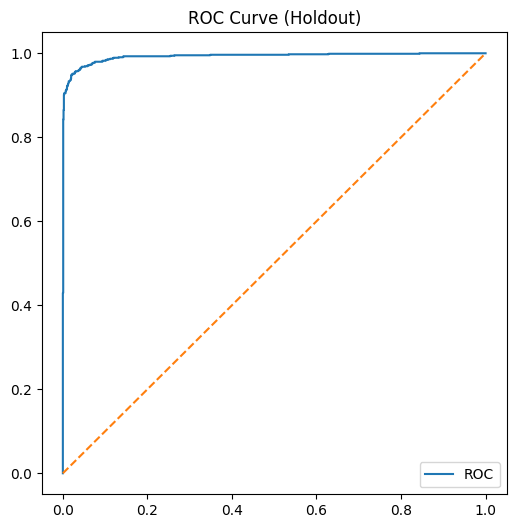

In [7]:
if __name__ == "__main__":
    extractor, tokenizer, tmodel, device, numeric_cols, final_model = build_and_evaluate()

## **Evaluation Metrics**

In [8]:
# %% [code]
val_files = list_files("../input/phishing-website-html-classification/validation")
val_paths, val_labels = zip(*val_files)
val_labels = np.array([1 if l.lower().startswith("phish") else 0 for l in val_labels])

raw_val = [read_file(p) for p in val_paths]

df_val, extra_val = extractor.transform(raw_val)
vis_val = extra_val["visible_texts"]
tag_val = extra_val["tag_sequences"]

emb_vis = embed_texts(tokenizer, tmodel, device, vis_val)
emb_tag = embed_texts(tokenizer, tmodel, device, tag_val)

Xn = df_val[numeric_cols].fillna(0).values.astype(np.float32)
X_val = np.hstack([Xn, emb_vis, emb_tag])

y_pred = final_model.predict(X_val)
try:
    y_proba = final_model.predict_proba(X_val)[:,1]
except:
    y_proba = np.zeros_like(y_pred)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

acc = accuracy_score(val_labels, y_pred)
prec = precision_score(val_labels, y_pred)
rec = recall_score(val_labels, y_pred)
f1 = f1_score(val_labels, y_pred)
auc = roc_auc_score(val_labels, y_proba)

print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)
print("F1:", f1)
print("AUC:", auc)

  0%|          | 0/2590 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

Accuracy: 0.967953667953668
Precision: 0.9700193423597679
Recall: 0.9507109004739337
F1: 0.9602680708472955
AUC: 0.9946496441638235


# **Inference + Explainability**
Fetch page → extract → embed → classify → SHAP explainability

Fetching: https://rhazys.com


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]


Prediction: 0 (1 = phishing)
Probability phishing = 0.06598092

Running SHAP explainability (numeric features only)...


The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


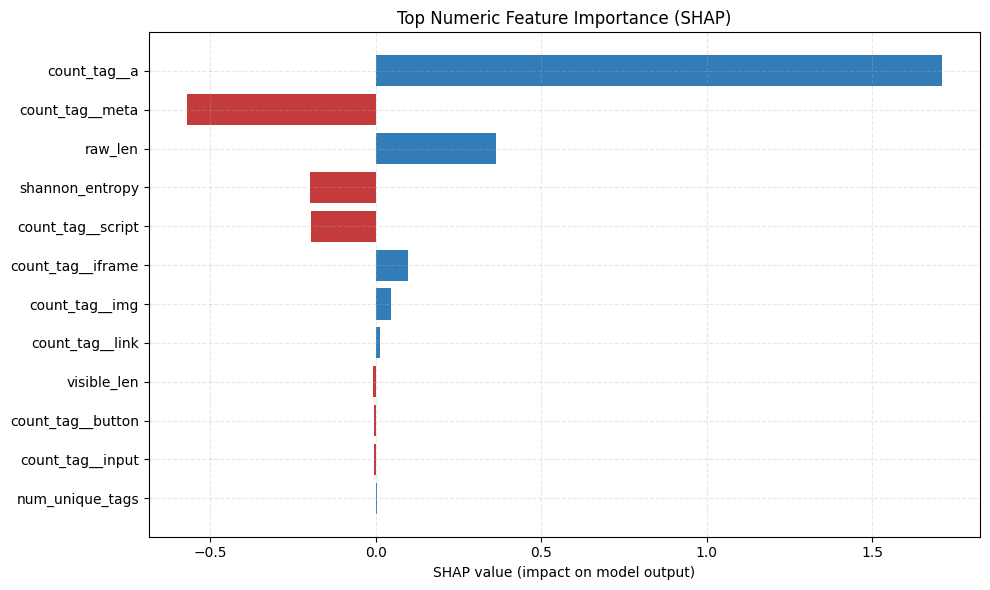

In [9]:
# Hardcoded test URL
TEST_URL = "https://rhazys.com"

print("Fetching:", TEST_URL)
resp = requests.get(TEST_URL, timeout=10)
html_page = resp.text

# Extract features
df_inf, extra_inf = extractor.transform([html_page])
vis_inf = extra_inf["visible_texts"]
tag_inf = extra_inf["tag_sequences"]

# Embeddings
emb_vis_inf = embed_texts(tokenizer, tmodel, device, vis_inf)
emb_tag_inf = embed_texts(tokenizer, tmodel, device, tag_inf)

Xn_inf = df_inf[numeric_cols].fillna(0).values.astype(np.float32)
X_inf = np.hstack([Xn_inf, emb_vis_inf, emb_tag_inf])

pred = final_model.predict(X_inf)[0]
proba = final_model.predict_proba(X_inf)[0,1]

print("\nPrediction:", pred, "(1 = phishing)")
print("Probability phishing =", proba)

# ---------------- SHAP ----------------
# %% [code]
print("\nRunning SHAP explainability (numeric features only)...")

explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_inf)

if isinstance(shap_values, list):
    sv = np.array(shap_values[0]).reshape(-1)
else:
    sv = np.array(shap_values).reshape(-1)

n_num = len(numeric_cols)
sv_num = sv[:n_num]

top_k = min(n_num, 12)
idx = np.argsort(-np.abs(sv_num))[:top_k]
names = [numeric_cols[i] for i in idx]
vals = sv_num[idx]

from matplotlib import cm
cmap = cm.get_cmap("RdBu")
colors = [cmap(0.15) if v < 0 else cmap(0.85) for v in vals]

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(names[::-1], vals[::-1], color=colors[::-1])
ax.set_title("Top Numeric Feature Importance (SHAP)")
ax.set_xlabel("SHAP value (impact on model output)")
ax.grid(alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()